# Machine Learning LAB 6: CLUSTERING - K-means and DBSCAN

Course 2025/26: *F. Chiariotti*

The notebook contains some simple tasks about **CLUSTERING**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Image segmentation with k-means

In this laboratory we will use the k-means algorithm to cluster a dataset of 3D points. We will apply **K-means** to the problem of image compression and image segmentation. The main idea is to apply k-means to the colors of the pixels of an image to select the k most representative colors. Then, we will replace each pixel color with the closest representative color. This will allow us to reduce the number of colors in the image and compress it. A color is a vector of 3 values (R,G,B) that represent the amount of red, green and blue in the color; this implies that each pixel is a point in a 3D space.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.

In the second part of the laboratory we will use a **linkage-based** clustering algorithm to cluster a dataset of 2D points and compare it with the results obtained with k-means.

---

## Import all the necessary Python libraries

In [2]:
%matplotlib inline  

import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import pyplot as plt

np.random.seed(20)

---

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `img_plot` -> function to plot an image with name and dimension as title,
2. `scatter_plot` -> function to plot a scatter plot of the data,
3. `scatter_plot_2d` -> function to plot a 2D scatter plot of the data,
4. `error_plot` -> function to plot the error of the k-means algorithm over the iterations,
5. `cluster_plot` -> function to plot the obtained clusters.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [3]:
def img_plot(img: np.ndarray, title: str = None) -> None:
    """
    Plot an image
    :param img: image to plot
    :param title: title of the plot
    """
    
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(f'{title}: {img.shape}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def scatter_plot(data: np.ndarray, clusters: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param data: data to plot
    :param clusters: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """
    
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue", rotation=90, labelpad=-1)
    if title is not None:
        plt.title(title)
    if clusters is None:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=data, s=5)
    else:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=clusters, s=1, cmap='viridis', zorder=0, alpha=0.5 )
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=400, zorder=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [5]:
def scatter_plot_2d(x: np.ndarray, y: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param x: data to plot
    :param y: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """

    fig = plt.figure()
    plt.scatter(x[:,0], x[:,1], c=y, marker="o", s=10, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def error_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    """
    Plot the errors over the iterations
    :param errors: errors to plot
    """
    
    if labels is None:
        plt.plot(errors[1:-1])
        plt.plot(errors[1:-1], 'ro')
    else:
        plt.plot(labels, errors)
        plt.plot(labels, errors, 'ro')
    plt.title('Error over iterations')
    plt.ylabel('Error')
    plt.xlabel('Iteration #')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

In [7]:
def cluster_plot(labels: np.ndarray, x: np.ndarray, title: str = None) -> None:
    """
    Plot the clusters
    :param labels: cluster labels
    :param x: data
    :param title: title of the plot
    """
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

---

## A) K-means clustering

Implement the K-means algorithm

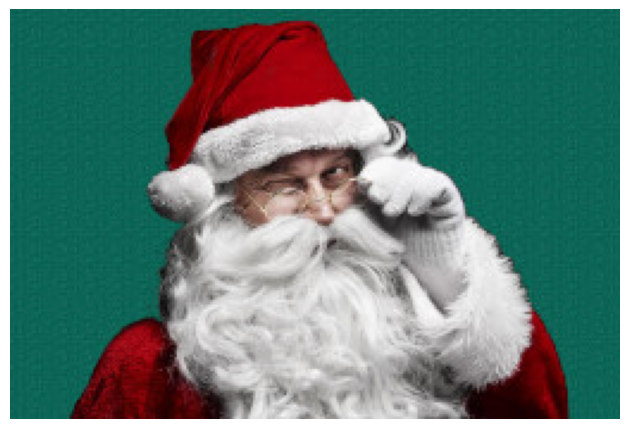

(172, 256, 3)


In [8]:
# Load the provided image and display it (if you like you can experiment with other images)
# To load the images use the function plt.imread(<path_to_iamge>)
santa = plt.imread("data/santaclaus2.jpg")

# Plot the image with its shape
img_plot(santa)
print(santa.shape)

In [9]:
# Reshape the data to a matrix of num_pixels x 3 
# (divide by 255 to have colors in [0 1] range for plotting functions of sklearn)
santa_reshaped = np.reshape(santa, (santa.shape[0]*santa.shape[1],santa.shape[2]))
santa_reshaped = santa_reshaped /255

# Print the shape of the data and the min and max values of the pixels
print("shape:",santa_reshaped.shape, "min:", np.min(santa_reshaped),"max:", np.max(santa_reshaped))

shape: (44032, 3) min: 0.0 max: 1.0


Plot the points in the 3-dimensional space with normalized intervals between 0 and 1 (corresponding to the three channels of the image, i.e. Red Green and Blue)

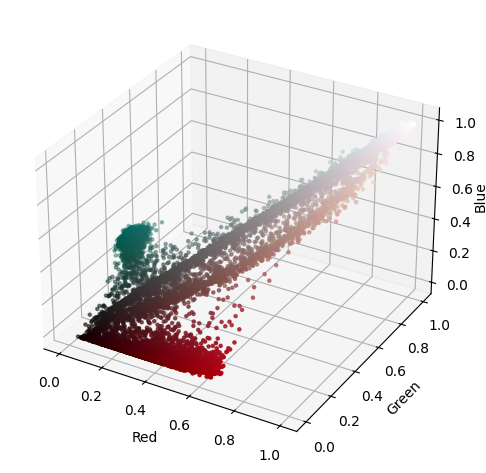

In [10]:
# Sugestion: use the function scatter_plot()
scatter_plot(santa_reshaped)

Implement the k-means algorithm manually (**do not use the kmeans function of sklearn and do not download implementations from other web sources**). The inputs to the function is the set of vectors to be clustered and the number of clusters. The output must contain the clusters barycenters, a vector associating each data point to the corresponding cluster and the error (value of the cost function) at each iteration.
Additionally, fix a maximum number of iterations of the k-means algorithm (e.g., 50).

Be careful about the initalization, you can use some random points from the training set, or get random values but ensure they are in the proper range. Poor initalizations can lead to the failure of the algorithm (in particular check that no cluster is initialized as empty, otherwise the algorithm can not update it).

In [ ]:
def kmeans(points: np.ndarray, k: int, max_iters: int = 50) -> tp.Tuple[np.ndarray, np.ndarray, list]:
    """
    Perform K-means clustering
    :param points: data points
    :param k: number of clusters
    :param max_iters: maximum number of iterations
    """

    # TODO Generate random centroids
    # Hint: Use the correct means and standard deviation to ensure they represent the whole input space
    point_count = points.shape[0]
    coord_count = points.shape[1]
    
    clusters = np.ndarray((point_count,))
    
    prev_error = 1e9+1
    error = [1e9]
    
    # Run the K-means algorithm: until the estimate of centroid is stable (or the maximum number of iterations is reached)
    iters = 0
    while (error[iters] != prev_error) and iters < max_iters:
        # TODO Measure the distance to every centroid
        # TODO Step 1: assign training data to closest centroid

        # TODO Calculate the new centroids for every cluster 
            
        prev_error = error[iters]
        current_error = 0 
        # TODO Update the total cost estimate
        error.append(current_error)
        
        # Update the iteration counter
        iters += 1

    return centroids, clusters, error

Now try the function you developed on the Santaclaus image with three clusters (k=3), then plot the data points in the 3-dimensional space, each point must be coloured based on the membership to one of the clusters. Additionally, plot the respective clusters centroids (use a different shape, size or color to highlight the centroids). Also, plot the total cost over each iteration

In [ ]:
# Run your K-means function on the data
kmeans_centroids, kmeans_clusters, kmeans_errors = kmeans(santa_reshaped, k=3)

# Print the errors:
print(kmeans_errors)

# Plot the results
scatter_plot(santa_reshaped, kmeans_clusters, kmeans_centroids)

# Plot the error
error_plot(kmeans_errors)

Now use the k-means function provided in sklearn. Pass to the function the number of clusters and use multiple random initializations (n_init parameter). Go to the documentation page for further details

In [ ]:
# Define the K-means model
km = KMeans(n_clusters=3,n_init=100)

# Fit the model to the data
santa_predicted = km.fit_predict(santa_reshaped)
santa_reshaped_compressed = np.copy(santa_reshaped)
for i in range(santa_reshaped_compressed.shape[0]):
    santa_reshaped_compressed[i]=km.cluster_centers_[santa_predicted[i]]

# Get the cluster centers
centers = km.cluster_centers_

Perform the same plot as above but with the output of the k-means function provided in sklearn.

In [ ]:
scatter_plot(santa_reshaped, santa_predicted, centers)

### TO DO [Answer the following] 

Compare the results obtained with your implementation and with k-means from sklearn. Do you observe any differences, *i.e.*, do the two plots match?

**ANSWER:** 

Now display the segmented image based on the clusters found above with the k-means functions by sklearn and by your own K-means implementation.

In [ ]:
# Extract the color values of the centers
color_centers = centers*255

# Reshape the data to the original image shape
santa_processed = np.reshape(santa_reshaped_compressed, santa.shape)

# Plot the recolored image
img_plot(santa_processed)

# Extract the color values of the centers
kmeans_color_centers = kmeans_centroids*255

# Reshape the data to the original image shape
kmeans_santa_reshaped_compressed = np.copy(santa_reshaped)
for i in range(kmeans_santa_reshaped_compressed.shape[0]):
    kmeans_santa_reshaped_compressed[i]=kmeans_centroids[int(kmeans_clusters[i])]
kmeans_santa_processed = np.reshape(kmeans_santa_reshaped_compressed, santa.shape)

# Plot the recolored image
img_plot(kmeans_santa_processed)

## B) DBSCAN clustering

Now, let's try DBSCAN: implement the algorithm with $\varepsilon=0.1$ and $M=10$ (i.e., the minimum number of neighbors). The output should be a list of indices for all points, indicating which cluster each point belongs to. Outliers are in cluster 0, all other points have a positive index. For efficiency, we should compute a distance matrix first. Additionally, since DBSCAN is much more complex, we will try it on a smaller dataset

In [ ]:
# Load sample data
data = np.load("data/moon_data.npz")

# Extract data
x = data['X']
print(x)
labels_true = data['labels_true']

In [ ]:
def distance_matrix(points):
    point_count = points.shape[0]
    distances = np.zeros((point_count, point_count))
    for i in range(point_count):
        array_points = np.asarray(points - points[i, :])
        distances[i, :] = np.linalg.norm(array_points,axis=1)
        distances[i,i] = 1e9
    return distances


def find_neighbors(distances, epsilon):
    return np.where(distances < epsilon)[0]


def dbscan(points, epsilon, M):
    point_count = points.shape[0]
    coord_count = points.shape[1]
    distances = distance_matrix(points)
    print(point_count)
    C = 0
    done = False
    # The clusters vector contains the assigned cluster values: -1 means unassigned, 0 means outlier, clusters have >=1 values
    clusters = -np.ones(point_count)
    while (not done):
        # TODO While there are still unassigned points, iterate over them
        # For each unassigned point, check if it is an outlier, expand over its neighbors if it is not                   
    return clusters

Let's try and plot it! Noise points will be in red. How do the clusters look like?

In [ ]:
clusters = dbscan(x, epsilon=0.1, M=10)
cluster_plot(clusters,x)

---